### The purpose of this notebook to is to recreate the regress the SSH in GLORYS onto the CWI developed in Amaya et al. (2022)

In [1]:
import os
os.chdir('/vortexfs1/home/anthony.meza/Atmospheric Rivers and Waves/scripts')
plotsdir = lambda x="": "/vortexfs1/home/anthony.meza/Atmospheric Rivers and Waves/plots/" + x
GLORYS_dir = lambda x="": "/vortexfs1/home/anthony.meza/GLORYS_data" + x
GLORYS_data_dir = lambda x="": "/vortexfs1/home/anthony.meza/Atmospheric Rivers and Waves/GLORYS_processed/" + x
ERA5_data_dir = lambda x="": "/vortexfs1/home/anthony.meza/Atmospheric Rivers and Waves/ERA5_data/" + x

In [2]:
from help_funcs import * 
# from eofs.xarray import Eof
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import importlib
import xarray as xr
import seaborn as sns
import pandas as pd
import cmocean.cm as cm
import netCDF4 as nc
from pathlib import Path
from natsort import natsorted
import matplotlib.pyplot as plt
import gsw
import gc
from multiprocessing import Pool
import os 
import multiprocessing
from os.path import exists
sns.set_context("notebook")
import dask_labextension

In [3]:
from pathlib import Path
from natsort import natsorted

In [4]:
def remove_seasonal(ds):
    climatology = ds.groupby("time.month").mean("time")
    anomalies = ds.groupby("time.month") - climatology
    return anomalies
def remove_daily_climatology(ds):
    climatology = ds.groupby("time.dayofyear").mean("time")
    anomalies = ds.groupby("time.dayofyear") - climatology
    return anomalies

In [5]:
from dask_jobqueue import SLURMCluster  # setup dask cluster 
cluster = SLURMCluster(
    cores=36,
    processes=1,
    memory='179GB',
    walltime='02:00:00',
    queue='compute',
    interface='ib0')
print(cluster.job_script())
cluster.scale(jobs=4)
from dask.distributed import Client
client = Client(cluster)

#!/usr/bin/env bash

#SBATCH -J dask-worker
#SBATCH -p compute
#SBATCH -n 1
#SBATCH --cpus-per-task=36
#SBATCH --mem=167G
#SBATCH -t 02:00:00

/vortexfs1/home/anthony.meza/.conda/envs/notebook_env/bin/python -m distributed.cli.dask_worker tcp://172.16.3.88:41972 --nthreads 36 --memory-limit 166.71GiB --name dummy-name --nanny --death-timeout 60 --interface ib0



In [6]:
client

Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://172.16.3.88:41972,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


### We read in the Amaya Coastal Wave Index Amplitude $(\text{Index} =  \sqrt{\text{PC1}^2 + \text{PC2}^2)}$ and Phase $(\text{Phase} = atan( {\frac{\text{PC1}}{\text{PC2}}}))$ and recompute $\text{PC1}$ and $\text{PC2}$. We also remove the leap-year days from the GLORYS dataset.

In [7]:
#read in Amaya Coastal wave index 
ikw_Idx = xr.open_dataset(r"../GLORYS_processed/ikw.daily.glorys.1993-2018.nc")
ikw_Idx["PC1"] = ikw_Idx.ikw_amp * np.cos(np.deg2rad(ikw_Idx.ikw_ph))
ikw_Idx["PC2"] = ikw_Idx.ikw_amp * np.sin(np.deg2rad(ikw_Idx.ikw_ph))

### Next we construct the the least-squares estimator to estimate coefficients $\alpha$ and $\beta$ to obtain the estimate $\hat{y} = \alpha (PC1) + \beta (PC2)$ 

In [8]:
def trend_estimator(x):
    E = np.ones((len(x), 2))
    E[:, 1] = x
    E_dag = np.linalg.inv(E.T @ E) @ E.T
    return E_dag[1, :]

def timeregress(y, x):
    y_nomean = y - y.mean(dim = "time")
    x_estimator = xr.DataArray(trend_estimator(x.values), 
                coords={'time': y.time}, 
                dims=["time"])
    return (x_estimator * y_nomean).sum(dim = "time")

def timeregress(y, x, beta):
    y_nomean = y - y.mean(dim = "time")
    return (beta * y_nomean).sum(dim = "time")

In [9]:
amp_estimator = xr.DataArray(trend_estimator(ikw_Idx.ikw_amp.values), 
                coords={'time': ikw_Idx.time}, 
                dims=["time"])
PC1_estimator = xr.DataArray(trend_estimator(ikw_Idx.PC1.values), 
                coords={'time': ikw_Idx.time}, 
                dims=["time"])
PC2_estimator = xr.DataArray(trend_estimator(ikw_Idx.PC2.values), 
                coords={'time': ikw_Idx.time}, 
                dims=["time"])

### Reading in the GLORYS data files. Files have been preprocessed and combined in order to take advantage of the **dask** feature of xarray 

In [7]:
%time
results = [str(result) for result in list(Path(GLORYS_dir()).rglob("*.[nN][cC]"))] #get all files
results = natsorted(results) #sort all files 
results = results[:-518] #only go to 2018

years = natsorted(list(set([result[41:45] for result in results])))
months = natsorted(['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12'])

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.25 µs


In [8]:
file_path = ERA5_data_dir()
ERA5_results = natsorted([str(result) for result in list(Path(file_path).rglob("*.[nN][cC]"))])[:-1]
results_ERA5 = natsorted([str(f) for f in ERA5_results if f[-7:-3] in years])

In [11]:
%%time 
def _preprocess(ds):
    return ds[["thetao", "zos"]].sel(latitude = slice(-2, 60), longitude = slice(-150, -75), time = slice("1993", "2018"))

ds = xr.open_mfdataset(
        GLORYS_data_dir("GLORYS_NE_PAC.nc"),
        data_vars="minimal",
        coords="minimal",
        compat="override",
        preprocess=_preprocess,
        parallel=True,
        chunks={"time":-1, "latitude":50, "longitude":50, "depth":2},
        engine="netcdf4")

CPU times: user 2.62 s, sys: 468 ms, total: 3.08 s
Wall time: 1min 11s


### Removing the seasonal cycle by removing the daily climatology 

In [13]:
%%time 
ds_climatology = xr.open_dataset(GLORYS_data_dir("GLORYS_SFC_Climatology.nc"),
        chunks={"latitude":50, "longitude":50, "depth":2},
        engine="netcdf4")
anomalies = ds.groupby("time.dayofyear") - ds_climatology

CPU times: user 152 ms, sys: 28.6 ms, total: 181 ms
Wall time: 765 ms


In [14]:
%%time 
theta_depth_full = ds.thetao.sel(depth = 50, latitude = 30, longitude = -116, method = "nearest").compute()
theta_depth_anomaly = anomalies.thetao.sel(depth = 50, latitude = 30, longitude = -116, method = "nearest").compute()

theta_full = ds.thetao.isel(depth = 0).sel(latitude = 30, longitude = -116, method = "nearest").compute()
theta_anomaly = anomalies.thetao.isel(depth = 0).sel(latitude = 30, longitude = -116, method = "nearest").compute()

eta_full = ds.zos.sel(latitude = 30, longitude = -116, method = "nearest").compute()
eta_anomaly = anomalies.zos.sel(latitude = 30, longitude = -116, method = "nearest").compute()

CPU times: user 3.56 s, sys: 260 ms, total: 3.82 s
Wall time: 1min 36s


CPU times: user 437 ms, sys: 24 ms, total: 461 ms
Wall time: 456 ms


[Text(0, 0.5, '[°C]'), Text(0, 0.5, '[°C]')]

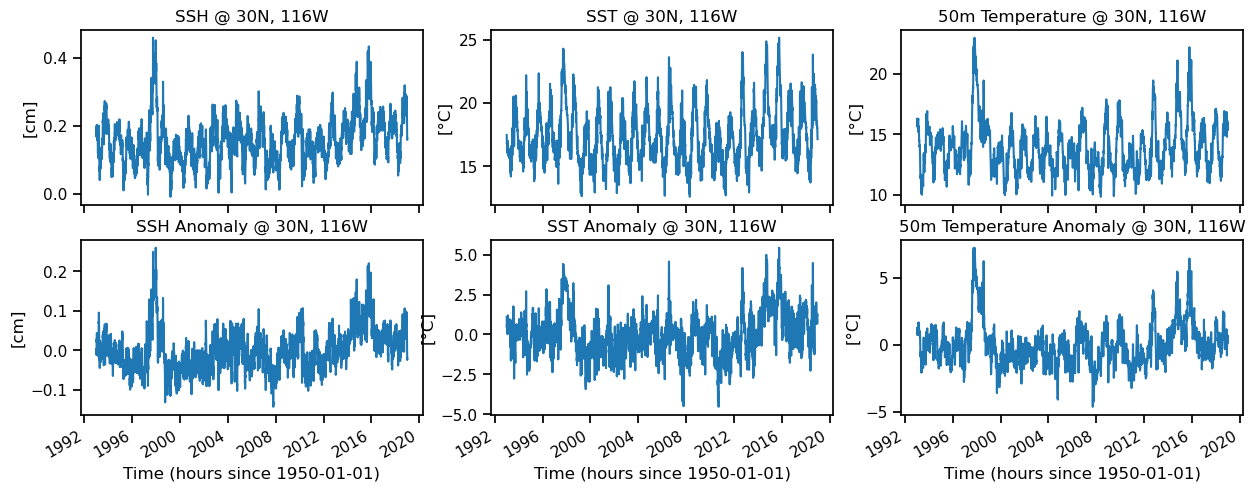

In [22]:
%%time 
#check that seasonal cycle has been removed 
fig, axes = plt.subplots(ncols = 3, nrows=2, figsize = (15, 5), sharex = True)
axs = axes.flatten()
eta_full.plot(ax = axs[0])
eta_anomaly.plot(ax = axs[3], label = "Daily Climatology Removed")
axs[0].set_xlabel("");
axs[0].set_title("SSH @ 30N, 116W"); axs[3].set_title("SSH Anomaly @ 30N, 116W")
[ax.set_ylabel("[cm]") for ax in axs[[0, 3]]]

theta_full.plot(ax = axs[1])
theta_anomaly.plot(ax = axs[4], label = "Daily Climatology Removed")
axs[1].set_xlabel("");
axs[1].set_title("SST @ 30N, 116W"); axs[4].set_title("SST Anomaly @ 30N, 116W")
[ax.set_ylabel("[°C]") for ax in axs[[1, 4]]]

theta_depth_full.plot(ax = axs[2])
theta_depth_anomaly.plot(ax = axs[5], label = "Daily Climatology Removed")
axs[2].set_xlabel("");
axs[2].set_title("50m Temperature @ 30N, 116W"); axs[5].set_title("50m Temperature Anomaly @ 30N, 116W")
[ax.set_ylabel("[°C]") for ax in axs[[2,5]]]


In [13]:
%%time 
ds["time"] = ds.indexes['time'].normalize()
ds = ds.sel(time = ikw_Idx.time)
anomalies["time"] = anomalies.indexes['time'].normalize()
anomalies = anomalies.sel(time = ikw_Idx.time)
# ds = ds[["thetao", "so", "zos"]]

NameError: name 'ds' is not defined

In [25]:
%%time
theta_anom = anomalies.thetao.isel(depth = 0) #SST anomaly
theta_depth = anomalies.thetao.isel(depth = 1) #SST anomaly
eta_anom = anomalies.zos #SSH anomaly

CPU times: user 1.91 ms, sys: 0 ns, total: 1.91 ms
Wall time: 1.93 ms


### Use the least-squares estimators to obtain regression coefficients for PC1 and PC2 for each variable 

In [28]:
%%time
#correlate geophysical variables with coastal wave index amplitude
regress_theta = timeregress(theta_anom, ikw_Idx.ikw_amp, amp_estimator).compute()
regress_theta_depth = timeregress(theta_depth, ikw_Idx.ikw_amp, amp_estimator).compute()
regress_eta = timeregress(eta_anom, ikw_Idx.ikw_amp, amp_estimator).compute()
regress_etasq_anom = timeregress(eta_anom**2, ikw_Idx.ikw_amp, amp_estimator).compute()

CPU times: user 28 s, sys: 1.44 s, total: 29.5 s
Wall time: 3min 45s


In [29]:
%%time
#correlate geophysical variables with coastal wave index amplitude
regress_theta_PC1 = timeregress(theta_anom, ikw_Idx["PC1"], PC1_estimator).compute()
regress_theta_depth_PC1 = timeregress(theta_depth, ikw_Idx["PC1"], PC1_estimator).compute()
regress_eta_PC1 = timeregress(eta_anom, ikw_Idx["PC1"], PC1_estimator).compute()
regress_etasq_anom_PC1 = timeregress(eta_anom**2, ikw_Idx["PC1"], PC1_estimator).compute()

CPU times: user 26.1 s, sys: 1.27 s, total: 27.4 s
Wall time: 3min 14s


In [33]:
%%time
#correlate geophysical variables with coastal wave index amplitude
regress_theta_PC2 = timeregress(theta_anom, ikw_Idx["PC2"], PC2_estimator).compute()
regress_theta_depth_PC2 = timeregress(theta_depth, ikw_Idx["PC2"], PC2_estimator).compute()
regress_eta_PC2 = timeregress(eta_anom, ikw_Idx["PC2"], PC2_estimator).compute()
regress_etasq_anom_PC2 = timeregress(eta_anom**2, ikw_Idx["PC2"], PC2_estimator).compute()

CPU times: user 27.7 s, sys: 1.45 s, total: 29.1 s
Wall time: 3min 4s


CPU times: user 1.56 s, sys: 38.7 ms, total: 1.6 s
Wall time: 1.58 s


[Text(0.5, 0, 'Longitude'),
 Text(0.5, 0, 'Longitude'),
 Text(0.5, 0, 'Longitude')]

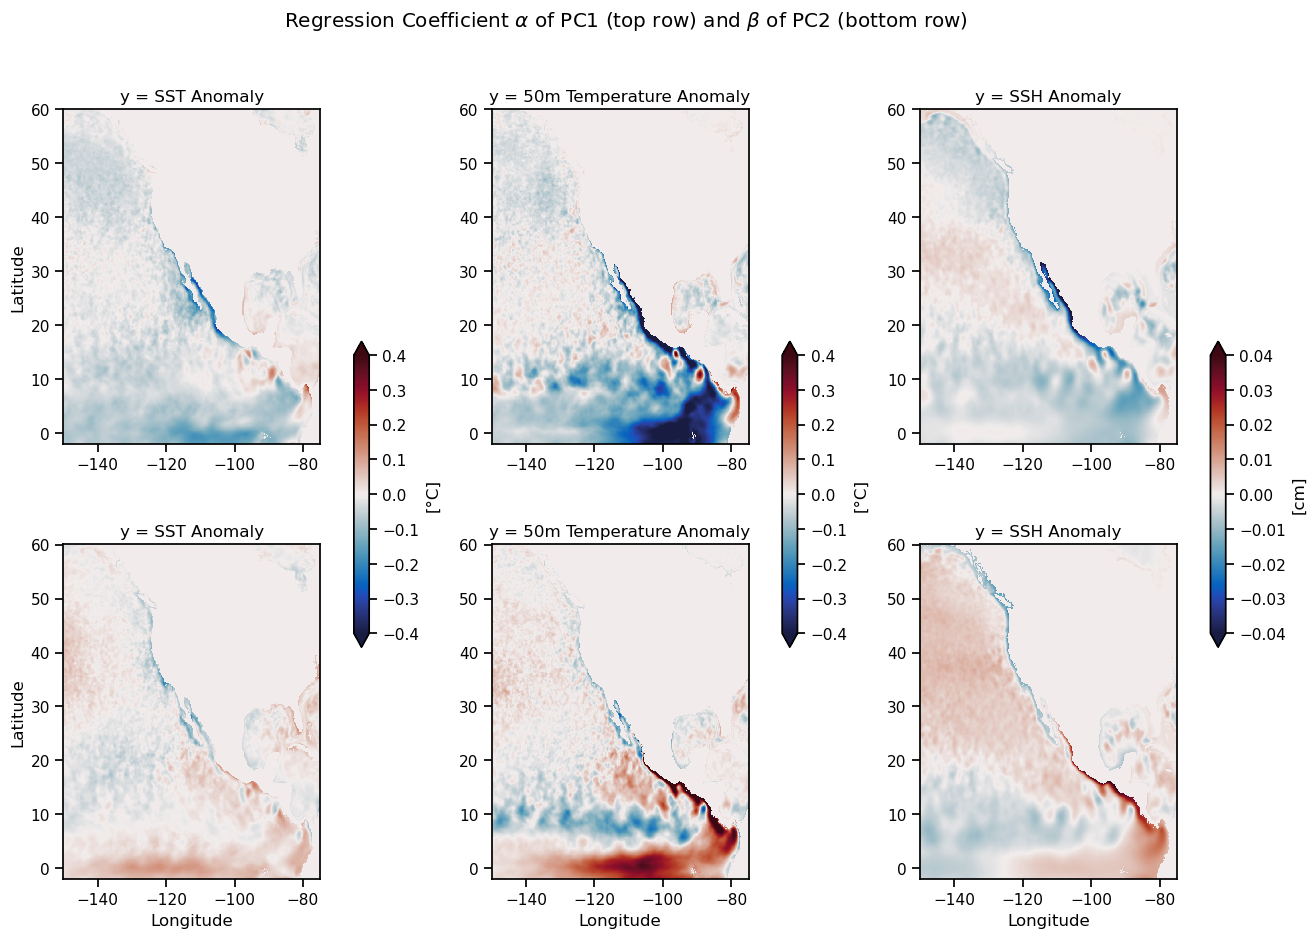

In [127]:
%%time 
#plot the regression coefficient for PC1
fig, axes = plt.subplots(ncols = 3, nrows =2, figsize = (15, 10))
fig.subplots_adjust(hspace = 0.3)
axs = axes[0, 0:3].flatten()
regress_theta_PC1.plot.pcolormesh(ax = axs[0], cmap = cm.balance, vmin = -0.4, vmax = 0.4, add_colorbar = False)
regress_theta_depth_PC1.plot.pcolormesh(ax = axs[1], cmap = cm.balance, vmin = -0.4, vmax = 0.4, add_colorbar = False)
regress_eta_PC1.plot.pcolormesh(ax = axs[2], cmap = cm.balance, vmin = -0.04, vmax = 0.04, add_colorbar = False)
fig.suptitle("Regression Coefficient " + r"$\alpha$" + " of PC1 ")
# fig.colorbar(cf, ax = axs)
axs[0].set_title("y = SST Anomaly")
axs[1].set_title("y = 50m Temperature Anomaly")
axs[2].set_title("y = SSH Anomaly")
[ax.set_ylabel("") for ax in axs]
axs[0].set_ylabel("Latitude")
[ax.set_xlabel("") for ax in axs]
fig.subplots_adjust(wspace = 0.4)

#plot the regression coefficient for PC2
axs = axes[1, 0:3].flatten()
regress_theta_PC2.plot.pcolormesh(ax = axs[0], cmap = cm.balance, vmin = -0.4, vmax = 0.4, add_colorbar = True, 
                                  cbar_kwargs = {"label":"[°C]", "extend": "both", "orientation":"vertical", "ax":axes[[0, 1], 0], "fraction":0.05, "pad":0.11})
regress_theta_depth_PC2.plot.pcolormesh(ax = axs[1], cmap = cm.balance, vmin = -0.4, vmax = 0.4, add_colorbar = True, 
                                        cbar_kwargs = {"label":"[°C]", "extend": "both", "orientation":"vertical", "ax":axes[[0, 1], 1], "fraction":0.05, "pad":0.11})
regress_eta_PC2.plot.pcolormesh(ax = axs[2], cmap = cm.balance, vmin = -0.04, vmax = 0.04, add_colorbar = True, 
                                cbar_kwargs = {"label":"[cm]", "extend": "both", "orientation":"vertical", "ax":axes[[0, 1], 2], "fraction":0.05, "pad":0.11})

fig.suptitle("Regression Coefficient " + r"$\alpha $" + " of PC1" + " (top row) and "r"$\beta$" + " of PC2 " + "(bottom row)")

axs[0].set_title("y = SST Anomaly")
axs[1].set_title("y = 50m Temperature Anomaly")
axs[2].set_title("y = SSH Anomaly")
[ax.set_ylabel("") for ax in axs]
axs[0].set_ylabel("Latitude")
[ax.set_xlabel("Longitude") for ax in axs]


### Now, we redo the previous analysis but for atmospheric variables in ERA5

In [12]:
def _preprocess_ERA5(ds):
    return ds.sel(latitude = slice(60, -2)).sel(longitude = slice(-150, -75)).sel(time = slice("1993", "2018"))

In [13]:
era5_ds = xr.open_mfdataset(GLORYS_data_dir("ERA5_NE_PAC_daily.nc"), 
        data_vars="minimal", coords="minimal",
        compat="override", preprocess=_preprocess_ERA5,
        parallel=True, chunks={"longitude": 119, "latitude":107, "time":-1}, engine="netcdf4")

In [16]:
era5_climatology = xr.open_dataset(ERA5_data_dir("ERA5_Daily_Climatology.nc"),
                    chunks={"longitude": 119, "latitude":107},
                    engine="netcdf4")

In [19]:
era5_anomalies = era5_ds.groupby("time.dayofyear") - era5_climatology

In [21]:
#try to do group by in the earliest stages of the computation 
tcwv_anom = era5_anomalies.tcwv
tp_anom   = era5_anomalies.tp
z500_anom = era5_anomalies.z

In [22]:
#try to do group by in the earliest stages of the computation 
tcwv_anom = tcwv_anom.sel(time = ikw_Idx.time)
tp_anom   = tp_anom.sel(time = ikw_Idx.time)
z500_anom = z500_anom.sel(time = ikw_Idx.time)

In [24]:
%%time
tcwv_ij = era5_ds.tcwv.sel(latitude = 30, longitude = -116, method = "nearest").compute()
tcwv_anom_ij = tcwv_anom.sel(latitude = 30, longitude = -116, method = "nearest").compute()

tp_ij = era5_ds.tp.sel(latitude = 30, longitude = -116, method = "nearest").compute()
tp_anom_ij = tp_anom.sel(latitude = 30, longitude = -116, method = "nearest").compute()

z500_ij = era5_ds.z.sel(latitude = 30, longitude = -116, method = "nearest").compute()
z500_anom_ij = z500_anom.sel(latitude = 30, longitude = -116, method = "nearest").compute()

CPU times: user 706 ms, sys: 71.4 ms, total: 777 ms
Wall time: 24.2 s


CPU times: user 315 ms, sys: 78.8 ms, total: 394 ms
Wall time: 2.08 s


[Text(0, 0.5, '[mm /day]'), Text(0, 0.5, '[mm /day]')]

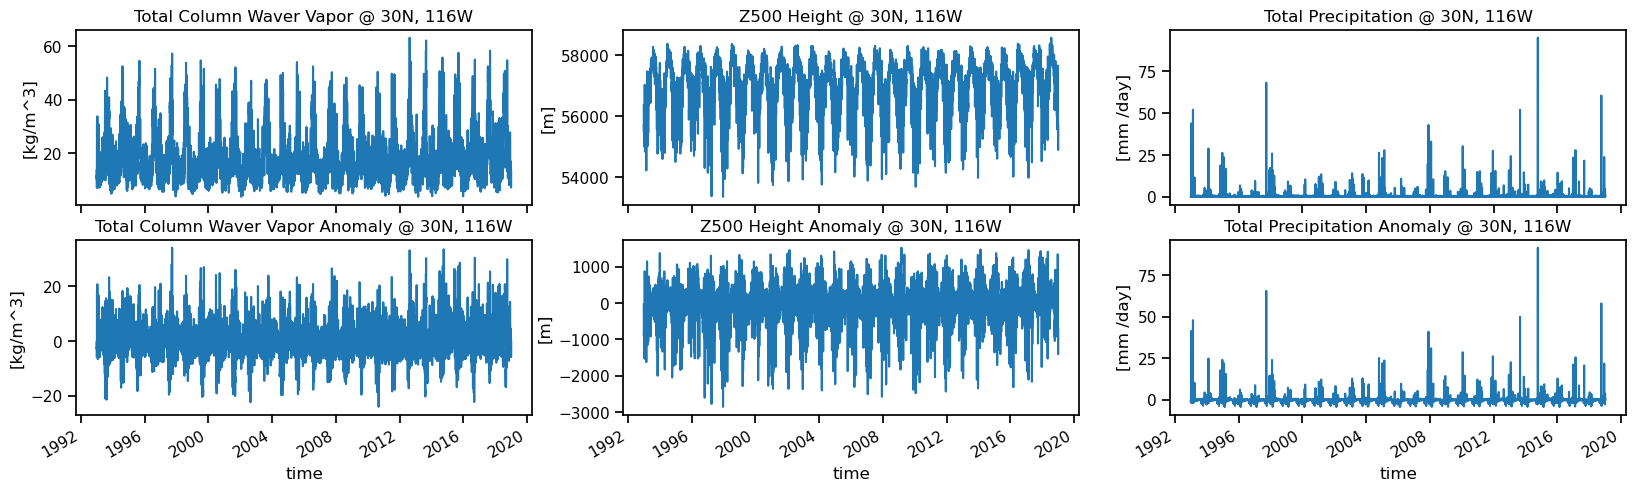

In [25]:
%%time 
#check that seasonal cycle has been removed 
fig, axes = plt.subplots(ncols = 3, nrows=2, figsize = (20, 5), sharex = True)
axs = axes.flatten()
tcwv_ij.plot(ax = axs[0])
tcwv_anom_ij.plot(ax = axs[3], label = "Daily Climatology Removed")
axs[0].set_xlabel("");
axs[0].set_title("Total Column Waver Vapor @ 30N, 116W"); axs[3].set_title("Total Column Waver Vapor Anomaly @ 30N, 116W")
[ax.set_ylabel("[kg/m^3]") for ax in axs[[0, 3]]]

z500_ij.plot(ax = axs[1])
z500_anom_ij.plot(ax = axs[4], label = "Daily Climatology Removed")
axs[1].set_xlabel("");
axs[1].set_title("Z500 Height @ 30N, 116W"); axs[4].set_title("Z500 Height Anomaly @ 30N, 116W")
[ax.set_ylabel("[m]") for ax in axs[[1, 4]]]

tp_ij.plot(ax = axs[2])
tp_anom_ij.plot(ax = axs[5], label = "Daily Climatology Removed")
axs[2].set_xlabel("");
axs[2].set_title("Total Precipitation @ 30N, 116W"); axs[5].set_title("Total Precipitation Anomaly @ 30N, 116W")
[ax.set_ylabel("[mm /day]") for ax in axs[[2,5]]]


In [1]:
ikw_Idx["PC1"].plot()

NameError: name 'ikw_Idx' is not defined

In [26]:
%%time
#correlate geophysical variables with coastal wave index amplitude
regress_tcwv_PC1 = timeregress(tcwv_anom, ikw_Idx["PC1"], PC1_estimator).compute()
regress_tp_PC1 = timeregress(tp_anom, ikw_Idx["PC1"], PC1_estimator).compute()
regress_z500_PC1 = timeregress(z500_anom, ikw_Idx["PC1"], PC1_estimator).compute()

CPU times: user 1.05 s, sys: 71 ms, total: 1.12 s
Wall time: 23.5 s


In [27]:
%%time
#correlate geophysical variables with coastal wave index amplitude
regress_tcwv_PC2 = timeregress(tcwv_anom, ikw_Idx["PC2"], PC2_estimator).compute()
regress_tp_PC2 = timeregress(tp_anom, ikw_Idx["PC2"], PC2_estimator).compute()
regress_z500_PC2 = timeregress(z500_anom, ikw_Idx["PC2"], PC2_estimator).compute()

CPU times: user 874 ms, sys: 49.7 ms, total: 924 ms
Wall time: 16.4 s


CPU times: user 173 ms, sys: 10.2 ms, total: 183 ms
Wall time: 180 ms


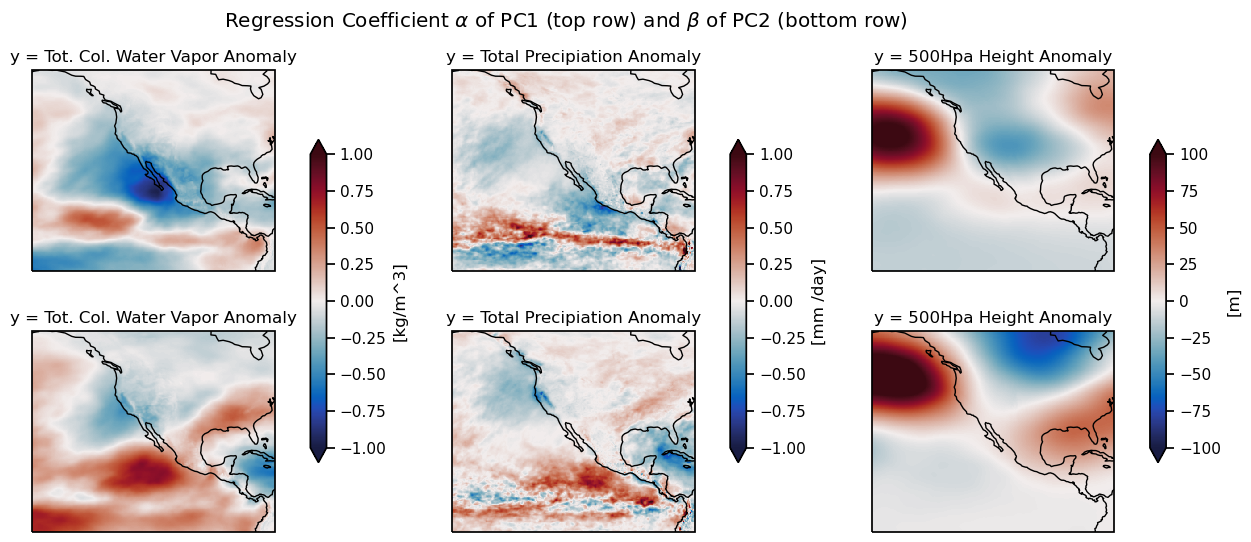

In [57]:
%%time 
import cartopy.crs as ccrs
#plot the regression coefficient for PC1
fig, axes = plt.subplots(ncols = 3, nrows =2, figsize = (15, 6), subplot_kw={'projection': ccrs.PlateCarree()})
fig.subplots_adjust(hspace = 0.3)
axs = axes[0, 0:3].flatten()
regress_tcwv_PC1.plot.pcolormesh(ax = axs[0], cmap = cm.balance, vmin = -1, vmax = 1, add_colorbar = False)
regress_tp_PC1.plot.pcolormesh(ax = axs[1], cmap = cm.balance, vmin = -1, vmax = 1, add_colorbar = False)
regress_z500_PC1.plot.pcolormesh(ax = axs[2], cmap = cm.balance, vmin = -100, vmax = 100, add_colorbar = False)
fig.suptitle("Regression Coefficient " + r"$\alpha$" + " of PC1 ")

axs[0].set_title("y = Tot. Col. Water Vapor Anomaly")
axs[1].set_title("y = Total Precipiation Anomaly")
axs[2].set_title("y = 500Hpa Height Anomaly")
[ax.set_ylabel("") for ax in axs]
axs[0].set_ylabel("Latitude")
[ax.set_xlabel("") for ax in axs]
fig.subplots_adjust(wspace = 0.3)
#plot the regression coefficient for PC2

axs = axes[1, 0:3].flatten()
regress_tcwv_PC2.plot.pcolormesh(ax = axs[0], cmap = cm.balance, vmin = -1, vmax = 1, add_colorbar = True, 
                                  cbar_kwargs = {"label":"[kg/m^3]", "extend": "both", "orientation":"vertical", "ax":axes[[0, 1], 0], "fraction":0.05, "pad":0.11})
regress_tp_PC2.plot.pcolormesh(ax = axs[1], cmap = cm.balance, vmin = -1, vmax = 1, add_colorbar = True, 
                                        cbar_kwargs = {"label":"[mm /day]", "extend": "both", "orientation":"vertical", "ax":axes[[0, 1], 1], "fraction":0.05, "pad":0.11})
regress_z500_PC2.plot.pcolormesh(ax = axs[2], cmap = cm.balance, vmin = -100, vmax = 100, add_colorbar = True, 
                                cbar_kwargs = {"label":"[m]", "extend": "both", "orientation":"vertical", "ax":axes[[0, 1], 2], "fraction":0.05, "pad":0.11})

fig.suptitle("Regression Coefficient " + r"$\alpha $" + " of PC1" + " (top row) and "r"$\beta$" + " of PC2 " + "(bottom row)")

axs[0].set_title("y = Tot. Col. Water Vapor Anomaly")
axs[1].set_title("y = Total Precipiation Anomaly")
axs[2].set_title("y = 500Hpa Height Anomaly")
[ax.set_ylabel("") for ax in axs]
axs[0].set_ylabel("Latitude")
[ax.set_xlabel("Longitude") for ax in axs]
[ax.coastlines() for ax in axes.flatten()]

CPU times: user 181 ms, sys: 3.92 ms, total: 184 ms
Wall time: 182 ms


[None, None, None, None, None, None]

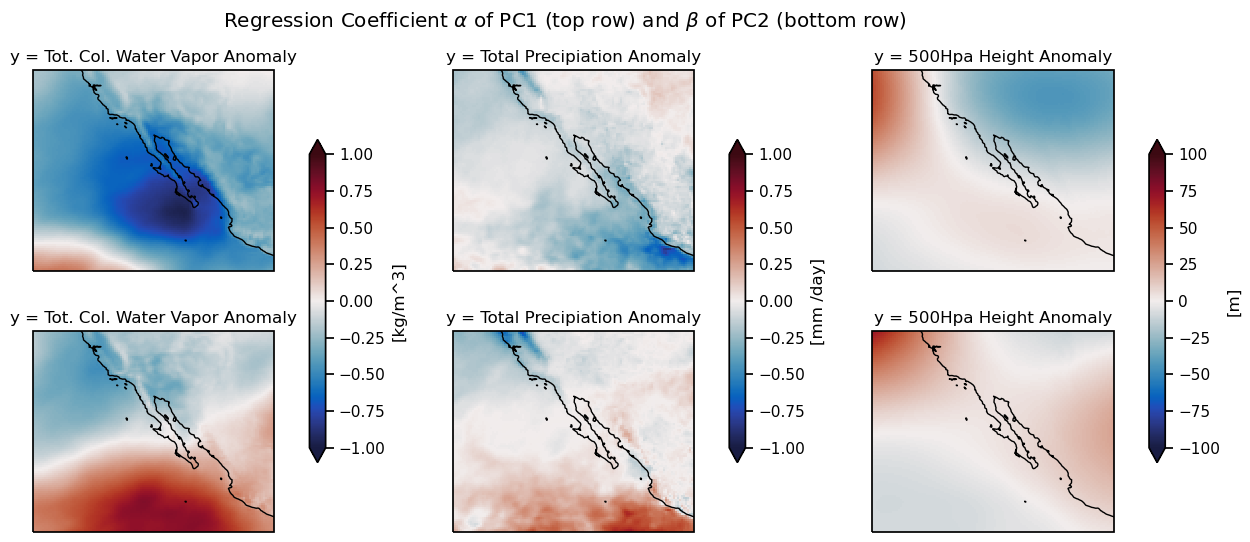

In [65]:
%%time 
import cartopy.crs as ccrs
#plot the regression coefficient for PC1
fig, axes = plt.subplots(ncols = 3, nrows =2, figsize = (15, 6), subplot_kw={'projection': ccrs.PlateCarree()})
fig.subplots_adjust(hspace = 0.3)
axs = axes[0, 0:3].flatten()
regress_tcwv_PC1.plot.pcolormesh(ax = axs[0], cmap = cm.balance, vmin = -1, vmax = 1, add_colorbar = False)
regress_tp_PC1.plot.pcolormesh(ax = axs[1], cmap = cm.balance, vmin = -1, vmax = 1, add_colorbar = False)
regress_z500_PC1.plot.pcolormesh(ax = axs[2], cmap = cm.balance, vmin = -100, vmax = 100, add_colorbar = False)
fig.suptitle("Regression Coefficient " + r"$\alpha$" + " of PC1 ")

axs[0].set_title("y = Tot. Col. Water Vapor Anomaly")
axs[1].set_title("y = Total Precipiation Anomaly")
axs[2].set_title("y = 500Hpa Height Anomaly")
[ax.set_ylabel("") for ax in axs]
axs[0].set_ylabel("Latitude")
[ax.set_xlabel("") for ax in axs]
fig.subplots_adjust(wspace = 0.3)
#plot the regression coefficient for PC2

axs = axes[1, 0:3].flatten()
regress_tcwv_PC2.plot.pcolormesh(ax = axs[0], cmap = cm.balance, vmin = -1, vmax = 1, add_colorbar = True, 
                                  cbar_kwargs = {"label":"[kg/m^3]", "extend": "both", "orientation":"vertical", "ax":axes[[0, 1], 0], "fraction":0.05, "pad":0.11})
regress_tp_PC2.plot.pcolormesh(ax = axs[1], cmap = cm.balance, vmin = -1, vmax = 1, add_colorbar = True, 
                                        cbar_kwargs = {"label":"[mm /day]", "extend": "both", "orientation":"vertical", "ax":axes[[0, 1], 1], "fraction":0.05, "pad":0.11})
regress_z500_PC2.plot.pcolormesh(ax = axs[2], cmap = cm.balance, vmin = -100, vmax = 100, add_colorbar = True, 
                                cbar_kwargs = {"label":"[m]", "extend": "both", "orientation":"vertical", "ax":axes[[0, 1], 2], "fraction":0.05, "pad":0.11})

fig.suptitle("Regression Coefficient " + r"$\alpha $" + " of PC1" + " (top row) and "r"$\beta$" + " of PC2 " + "(bottom row)")

axs[0].set_title("y = Tot. Col. Water Vapor Anomaly")
axs[1].set_title("y = Total Precipiation Anomaly")
axs[2].set_title("y = 500Hpa Height Anomaly")
[ax.set_ylabel("") for ax in axs]
axs[0].set_ylabel("Latitude")
[ax.set_xlabel("Longitude") for ax in axs]
[ax.coastlines() for ax in axes.flatten()]
[ax.set_extent([-130, -100, 15, 40], crs=ccrs.PlateCarree()) for ax in axes.flatten()]

for ax in axes.flatten():
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=2, color='gray', alpha=0.0, linestyle='--')
    gl.xlabels_top = False
    gl.ylabels_left = False

